In [1]:
import astropy.units as u
import pytest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ctapipe.image import tailcuts_clean, toymodel
from ctapipe.image.muon import MuonRingFitter
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
#from ctapipe.visualization.bokeh import ArrayDisplay

from scipy.ndimage import correlate1d

from scipy.stats import multivariate_normal, norm, skewnorm, uniform

In [2]:
import astropy.units as u
import pytest

from ctapipe.image import tailcuts_clean, toymodel
from ctapipe.image.muon import MuonRingFitter

In [3]:
from ctapipe.instrument import SubarrayDescription

In [4]:
#subarr=SubarrayDescription.read(
#        "dataset://corsika_theta_20.0_az_180.0_run10.simtel.gz",
#        focal_length_choice="EQUIVALENT")

In [5]:
#subarr=SubarrayDescription.read(
#        "dataset://gamma_test_large.simtel.gz",
#        focal_length_choice="EQUIVALENT")

In [6]:
subarr=SubarrayDescription.read(
        "dataset://gamma_prod5.simtel.zst",
        focal_length_choice="EQUIVALENT")

In [7]:
#ArrayDisplay(subarr).values

In [8]:
#for i in np.arange(len(subarr.tel)):
#    print(i," ",subarr.tel[int(i+1)].camera.geometry.name)

In [9]:
#SST-1M DigiCam (corsika_theta_20.0_az_180.0_run10.simtel.gz)
#geom = subarr.tel[4].camera.geometry
#optics = subarr.tel[4].optics

#Mace (corsika_theta_20.0_az_180.0_run10.simtel.gz)
#geom = subarr.tel[1].camera.geometry
#optics = subarr.tel[1].optics


#LST LSTCam
geom = subarr.tel[1].camera.geometry
optics = subarr.tel[1].optics
#MST FlashCam
#geom = subarr.tel[5].camera.geometry
#optics = subarr.tel[5].optics
#MST NectarCam
#geom = subarr.tel[100].camera.geometry
#optics = subarr.tel[100].optics
#SST CHEC
#geom = subarr.tel[60].camera.geometry
#optics = subarr.tel[60].optics

#geom = subarr.tel[50].camera.geometry

#geom = subarr.tel[8].camera.geometry
#def prod5_mst_flashcam(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[5]
#def prod5_mst_nectarcam(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[100]
#def prod5_lst(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[1]
#def prod5_sst(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[60]

In [10]:
geom

CameraGeometry(name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>)

In [11]:
tel_fov = np.arctan((np.max( np.sqrt(geom.pix_x ** 2 + geom.pix_y ** 2 ) ) * 2.0) / optics.effective_focal_length)

In [12]:
optics

OpticsDescription(name=LST, size_type=LST, reflector_shape=PARABOLIC, equivalent_focal_length=28.00 m, effective_focal_length=29.31 m, n_mirrors=1, mirror_area=386.73 m2)

In [13]:
#optics.mirror_area.to_value()
lst_mirror_area = 386.7332458496094
lst_muon_npe = 2500
expected_npe = lst_muon_npe * optics.mirror_area.to_value() / lst_mirror_area
print(expected_npe)

2500.0


In [14]:
optics.effective_focal_length

<Quantity 29.30565071 m>

In [15]:
geom.name

'LSTCam'

In [16]:
geom.frame

<CameraFrame Frame (focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>

In [17]:
geom.pix_rotation= 90 * u.deg

In [18]:
# flashCam example
#center_xs = optics.effective_focal_length * np.tan(( -2.5 * u.deg).to_value(u.rad))
#center_ys = optics.effective_focal_length * np.tan((  1.3 * u.deg).to_value(u.rad))
#radius = optics.effective_focal_length * np.tan(( 1.1 * u.deg).to_value(u.rad))
center_xs = geom.frame.focal_length * np.tan(( -0.3 * u.deg).to_value(u.rad))
center_ys = geom.frame.focal_length * np.tan((  0.4 * u.deg).to_value(u.rad))
radius = geom.frame.focal_length * np.tan(( 1.1 * u.deg).to_value(u.rad))

width = 0.1 * radius 

muon_model = toymodel.RingGaussian(
    x=center_xs,
    y=center_ys,
    radius=radius,
    sigma=width,
    rho=0.5,
    phi0=-40.0 * u.deg)

In [19]:
circumference = 2 * np.pi * radius
oversampling = 3
pixels_on_circle = circumference / geom.pixel_width[0] * oversampling

print(center_xs)
print(center_ys)
print(radius)
print(circumference)
print(pixels_on_circle)

print(oversampling)

-0.14660899695960355 m
0.1954800520539014 m
0.537627465416258 m
3.3780129914396335 m
206.8171270081961
3


In [20]:
charge, _, _ = muon_model.generate_image(
        geom,
        intensity=3000,
        nsb_level_pe=0,
    )
survivors = tailcuts_clean(geom, charge, 2, 1)

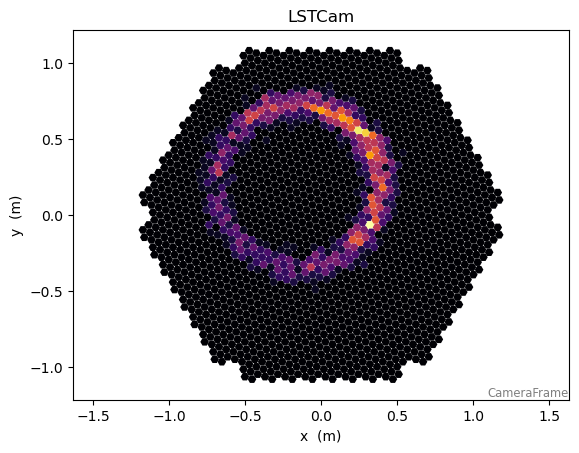

In [21]:
disp = CameraDisplay(geom,charge)

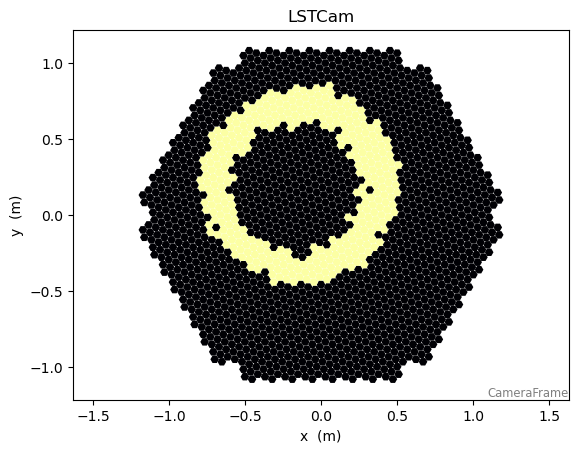

In [22]:
disp_s = CameraDisplay(geom,survivors)

In [23]:
rr=np.sqrt((geom.pix_y[survivors]-center_ys)*(geom.pix_y[survivors]-center_ys) + (geom.pix_x[survivors]-center_xs)*(geom.pix_x[survivors]-center_xs))

In [24]:
angle = np.arctan2(geom.pix_y[survivors]-center_ys,geom.pix_x[survivors]-center_xs).to(u.deg).to_value()

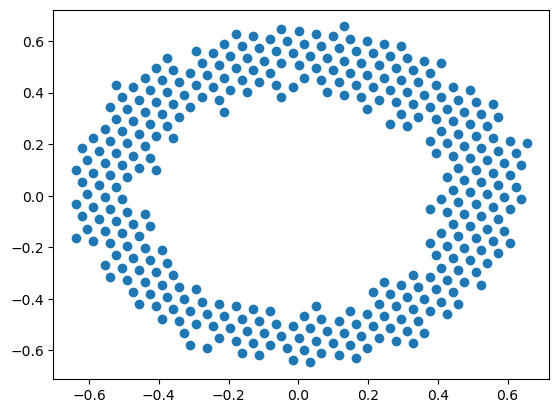

In [25]:
plt.plot((geom.pix_y[survivors]-center_ys),(geom.pix_x[survivors]-center_xs),'o')

In [26]:
len(charge[survivors])

346

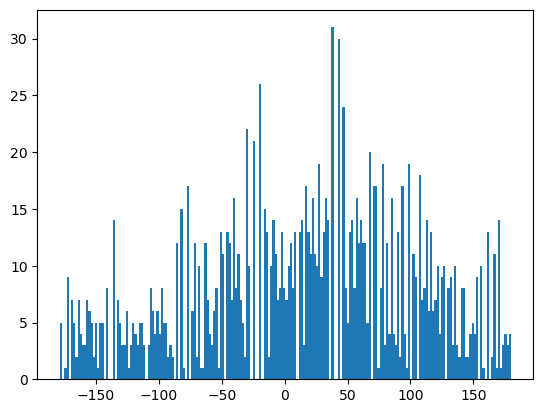

In [27]:
hist=plt.hist(angle,bins=int(pixels_on_circle),weights=charge[survivors])

In [28]:
#hist=plt.hist(angle,bins=int(pixels_on_circl),weights=charge[survivors])

In [29]:
360/int(pixels_on_circle)

1.7475728155339805

In [30]:
hist_bin_center = [(hist[1][i+1] + hist[1][i])/2.0 for i in np.arange(len(hist[0]))]

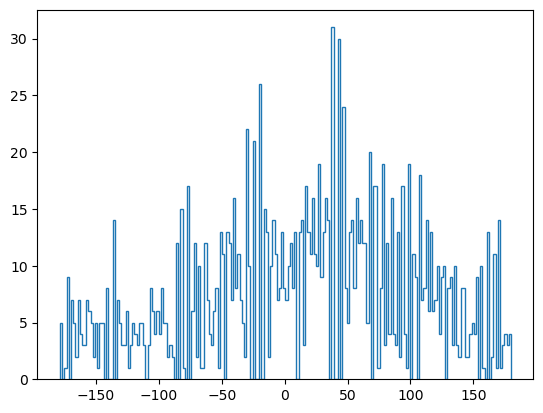

In [31]:
plt.stairs(hist[0],hist[1])

In [32]:
len(hist[0])

206

In [54]:
length = correlate1d(hist[0], np.ones(25), mode="wrap", axis=0)/3

Text(0.5, 0, 'phi, deg')

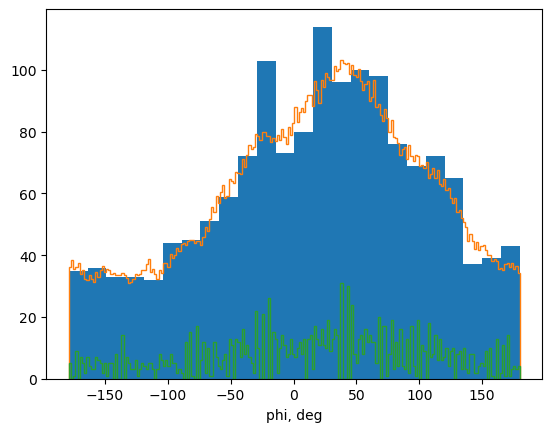

In [55]:
plt.hist(angle,bins=int(24),weights=charge[survivors])
plt.stairs(length,hist[1])
plt.stairs(hist[0],hist[1])
plt.xlabel('phi, deg')

(array([ 3.,  1.,  6., 13., 32., 54., 55., 22., 14.,  6.]),
 array([-18.44444444, -15.13333333, -11.82222222,  -8.51111111,
         -5.2       ,  -1.88888889,   1.42222222,   4.73333333,
          8.04444444,  11.35555556,  14.66666667]),
 <BarContainer object of 10 artists>)

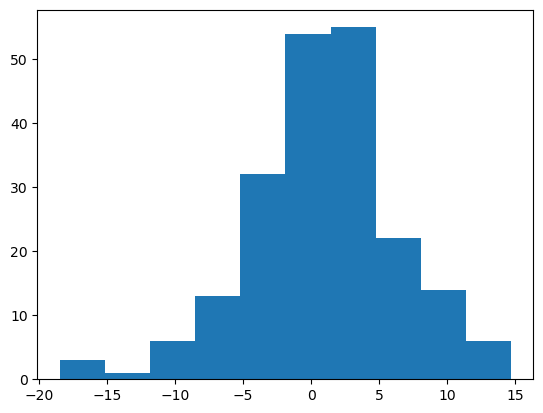

In [35]:
plt.hist(length/3.0 - hist[0])

(array([125.,  83.,  63.,  17.,  28.,  19.,   4.,   4.,   1.,   2.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

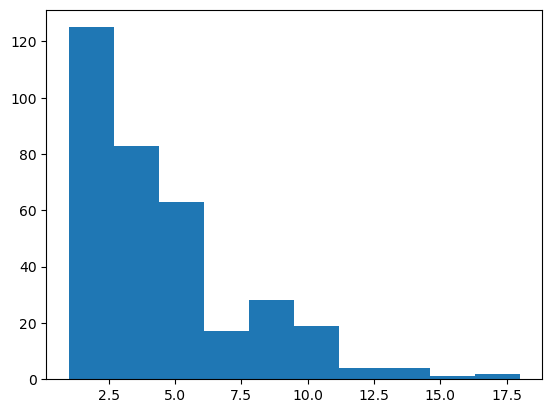

In [36]:
plt.hist(charge[survivors])

In [37]:
print(center_xs)
print(center_ys)
print(radius)

-0.14660899695960355 m
0.1954800520539014 m
0.537627465416258 m


In [38]:
geom.pixel_width

<Quantity [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049] m>

In [39]:
np.sum(disp.image.data)

np.float64(1514.0)

In [40]:
type(disp)

ctapipe.visualization.mpl_camera.CameraDisplay

(array([1.5e+03, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 8.0e+01, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 5.4e+01, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 5.6e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 2.7e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 3.6e+01,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.7e+01, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 1.7e+01, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.6e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 1.2e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+01,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 9.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 4.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        3.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
      

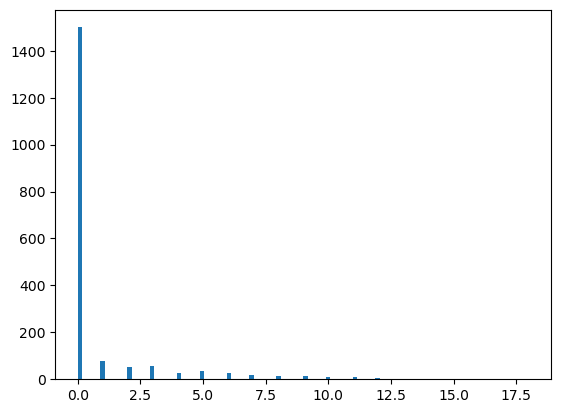

In [41]:
plt.hist(charge,bins=100)

In [42]:
df=pd.DataFrame(data=np.column_stack([charge,geom.pix_x.to_value(),geom.pix_y.to_value()]),columns=["charge","pix_x","pix_y"])

<Axes: >

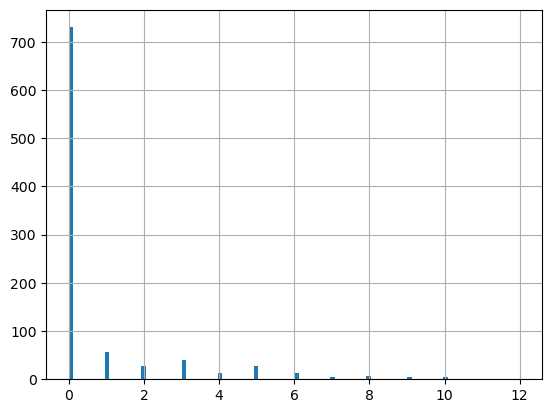

In [43]:
df[df["pix_x"]<0.0]["charge"].hist(bins=100)

In [44]:
np.sum(df[df["pix_x"]<0.0]["charge"].values)

np.float64(670.0)

In [45]:
df_cut=df[df["pix_x"]>0.0]

In [46]:
df_cut=df_cut[df_cut["pix_y"]>-0.25]

In [47]:
np.sum(df_cut["charge"].values)

np.float64(781.0)

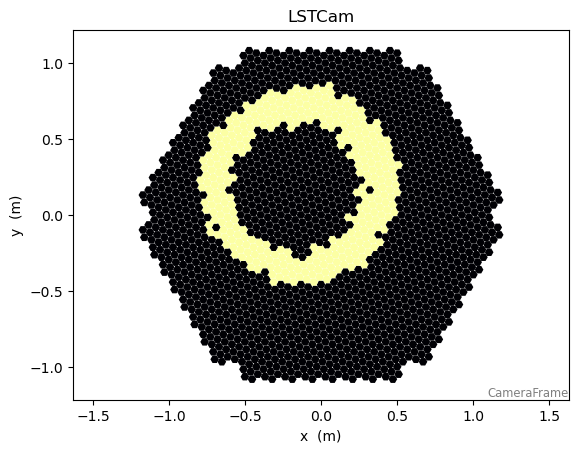

In [48]:
disp = CameraDisplay(geom,survivors)

In [49]:
arr = np.array([2, -3, 0, 4, -1, 7])

# Apply the transformation
result = np.where(arr < 0, arr * -1.0, arr).sum()

print("Original array:", arr)
print("Transformed array:", result)

Original array: [ 2 -3  0  4 -1  7]
Transformed array: 17.0


In [50]:
u.isclose((0.0 * u.m),(0.1 * u.m))

np.False_

In [51]:
disp = CameraDisplay(geom,image)

NameError: name 'image' is not defined

In [ ]:
dist=uniform(-0.2, 0.2)        
dist.pdf(0.0)

In [ ]:
x = np.linspace(-1.0, 1.0, 10000)
plt.plot(x, (np.sqrt(dist.pdf(x))),'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
np.zeros(x.shape)

In [ ]:
mc_h5_table

In [ ]:
muon_h5_table=h5file.root.dl1.event.telescope.muon.tel_001

In [ ]:
muon_h5_table

In [ ]:
muon_h5_table[0]

In [ ]:
tel_id=1
#h5filename="./data/run_000/dl1_muon_ctapipe_run000.h5"
h5filename="./data/dl1_muon_ctapipe.h5"
subarray = SubarrayDescription.from_hdf(h5filename)
geom = subarray.tel[tel_id].camera.geometry

In [ ]:
geom

In [ ]:
focal_length = subarray.tel[tel_id].optics.effective_focal_length

In [ ]:
focal_length.to_value()

In [ ]:
trigger_table = read_table(h5filename, "/dl1/event/subarray/trigger")
simshower_table = read_table(h5filename, "/simulation/event/subarray/shower")
mu_reco_table = read_table(h5filename, "/dl1/event/telescope/muon/tel_001")
#image_table = read_table(h5filename, "/dl1/event/telescope/images/tel_001")
#true_image_table = read_table(h5filename, "/simulation/event/telescope/images/tel_001")
#

In [ ]:
mu_table = join(left=trigger_table,
                right=mu_reco_table,
                keys=["obs_id", "event_id"])

In [ ]:
mu_table = join(left=mu_table,
                right=simshower_table,
                keys=["obs_id", "event_id"])

In [ ]:
mu_table.sort(["obs_id", "event_id"])

In [ ]:
mu_table

In [ ]:
keys_list=['obs_id',
 'event_id',
 'muonring_center_fov_lon',
 'muonring_center_fov_lat',
 'muonring_radius',
 'muonring_center_phi',
 'muonring_center_distance',
 'muonparameters_containment',
 'muonparameters_completeness',
 'muonparameters_intensity_ratio',
 'muonparameters_mean_squared_error',
 'muonparameters_ring_intensity',
 'muonparameters_intensity_outside_ring',
 'muonparameters_n_pixels_in_ring',
 'muonparameters_mean_intensity_outside_ring',
 'muonparameters_radial_std_dev',
 'muonparameters_skewness',
 'muonparameters_excess_kurtosis',
 'muonefficiency_width',
 'muonefficiency_impact',
 'muonefficiency_impact_x',
 'muonefficiency_impact_y',
 'muonefficiency_optical_efficiency',
 'muonefficiency_is_valid',
 'muonefficiency_parameters_at_limit',
 'muonefficiency_likelihood_value',
 'true_energy',
 'true_alt',
 'true_az',
 'true_core_x',
 'true_core_y',
 'true_h_first_int',
 'true_x_max',
 'true_starting_grammage',
 'true_shower_primary_id']

In [ ]:
mu_table_tr=mu_table[keys_list]

In [ ]:
df_mu=mu_table_tr.to_pandas()

In [ ]:
#df_mu.fillna

In [ ]:
arr_val=np.int32(df_mu['muonring_radius'].isna())

In [ ]:
arr_val

In [ ]:
arr_val_it=np.arange(len(arr_val))

In [ ]:
arr_val_it

In [ ]:
the_arr=arr_val*arr_val_it

In [ ]:
the_arr=the_arr[the_arr>0]

In [ ]:
plt.hist(the_arr,bins=10)

In [ ]:
df_mu_clean=df_mu.dropna()

In [ ]:
df_mu_clean=df_mu_clean.copy()

In [ ]:
len(df_mu_clean)/len(df_mu)

In [ ]:
plt.hist(df_mu_clean['muonefficiency_impact_x']-df_mu_clean['true_core_x'])

In [ ]:
plt.scatter(df_mu_clean['muonefficiency_impact_x'],df_mu_clean['muonefficiency_impact_y'],alpha=0.01)

In [ ]:
plt.hist2d(df_mu_clean['muonefficiency_impact_x'],df_mu_clean['muonefficiency_impact_y'],bins=100);

In [ ]:
plt.hist2d(df_mu_clean['true_core_x'],df_mu_clean['true_core_y'],bins=100);

In [ ]:
plt.hist(df_mu_clean['true_core_x'],bins=100);

In [ ]:
plt.hist(df_mu_clean['muonefficiency_impact_x'],bins=100);

In [ ]:
plt.hist(df_mu_clean['muonefficiency_impact_y'],bins=100);

In [ ]:
len(df_mu_clean)

In [ ]:
df_mu_clean['muonefficiency_impact_r'] = np.sqrt(df_mu_clean['muonefficiency_impact_x'].values*df_mu_clean['muonefficiency_impact_x'].values + df_mu_clean['muonefficiency_impact_y'].values*df_mu_clean['muonefficiency_impact_y'].values)

In [ ]:
df_mu_clean['true_core_r'] = np.sqrt(df_mu_clean['true_core_x']*df_mu_clean['true_core_x'] + df_mu_clean['true_core_y']*df_mu_clean['true_core_y'] )

In [ ]:
plt.hist(df_mu_clean['true_core_r']-df_mu_clean['muonefficiency_impact_r'])

In [ ]:
np.std(df_mu_clean['true_core_r']-df_mu_clean['muonefficiency_impact_r'])

In [ ]:
np.std(df_mu_clean['true_core_y']-df_mu_clean['muonefficiency_impact_y'])

In [ ]:
h5_event_id=the_h5_table[:]['event_id']
h5_mc_core_e=the_h5_table[:]['mc_energy']
h5_mc_core_x=the_h5_table[:]['mc_core_x']
h5_mc_core_y=the_h5_table[:]['mc_core_y']

In [ ]:
df_h5 = pd.DataFrame(np.array([h5_event_id,h5_mc_core_e,h5_mc_core_x,h5_mc_core_y]).transpose(), columns=['h5_event_id', 'mc_energy','h5_mc_core_x', 'h5_mc_core_y'])

In [ ]:
df_h5['impact_r_array'] = np.sqrt(df_h5['h5_mc_core_x']*df_h5['h5_mc_core_x']+df_h5['h5_mc_core_y']*df_h5['h5_mc_core_y'])

In [ ]:
df_h5_filter=df_h5[df_h5['h5_event_id'].isin(df_mu_good['event_id'].values)]

In [ ]:
df_h5_filter['']

In [ ]:
len(df_h5)/10000.0

In [ ]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

In [ ]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

In [ ]:
np.std(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

In [ ]:
plt.hist(df_h5_filter['h5_mc_core_y'].values-df_mu_good['impact_y_array'].values)

In [ ]:
df_mu_good_copy = df_mu_good.copy(deep=True)

In [ ]:
std_y_list=[]
std_x_list=[]
i_list=[]
for i in np.arange(0,360, 1):
    df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(i/180.0*np.pi)
    df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(i/180.0*np.pi)
    std_y=np.std(df_h5_filter['h5_mc_core_y'].values-df_mu_good_copy['impact_y_bar_array'].values)
    std_x=np.std(df_h5_filter['h5_mc_core_x'].values-df_mu_good_copy['impact_x_bar_array'].values)
    std_y_list.append(std_y)
    std_x_list.append(std_x)
    i_list.append(i)
    #print(i," ",std_y," ",std_x)

std_y_list=np.array(std_y_list)
std_x_list=np.array(std_x_list)
i_list=np.array(i_list)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_x_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(std_x_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
print(np.argmin(std_y_list))
print(np.argmin(std_y_list))
print(360.0-i_list[268])

In [ ]:
df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(268/180.0*np.pi)
df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(268/180.0*np.pi)   

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
np.std(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values)

In [ ]:
np.std(df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['ring_center_x'],df_mu['ring_center_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

#ax.legend()
    #ax.set_xlim(0,200)
#ax.set_yscale("log")
#a

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['impact_x_array'],df_mu['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['mc_energy'],df_mu['ring_radius'],alpha=0.1)
ax.set_xlim(0.03,0.2)
ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
df_mu_all_good=df_mu[df_mu['good_ring']==True]

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df_mu_all_good['ring_radius'].values,bins=100,alpha=1)
#ax.set_xlim(0.03,0.2)
#ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu_all_good['impact_x_array'],df_mu_all_good['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_h5['h5_mc_core_x'],df_h5['h5_mc_core_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [ ]:
bins=plt.hist(df_mu['ring_center_r'].values, bins=100)

In [ ]:
the_h5_table

In [ ]:
np.mean(df_mu['mc_energy'].values)

In [ ]:
df_mu['mc_energy'].hist(bins=100)

In [ ]:
np.mean(df_mu['ring_center_x'].values)

In [ ]:
the_h5_table

In [ ]:
h5_out_obs_id=the_h5_table[:]['obs_id']
h5_out_event_id=the_h5_table[:]['event_id']
h5_out_mc_energy=the_h5_table[:]['mc_energy']
h5_out_mc_core_x=the_h5_table[:]['mc_core_x']
h5_out_mc_core_y=the_h5_table[:]['mc_core_y']
h5_out_mc_alt=the_h5_table[:]['mc_alt']
h5_out_mc_az=the_h5_table[:]['mc_az']

In [ ]:
the_h5_table_image=h5file.root.dl1.event.telescope.image.LST_LSTCam

In [ ]:
image_charge_arr=the_h5_table_image[:]['image']

In [ ]:
image_time_arr=the_h5_table_image[:]['peak_time']

In [ ]:
meta_data_arr=np.array([h5_out_obs_id,h5_out_event_id,h5_out_mc_energy,h5_out_mc_core_x,h5_out_mc_core_y,h5_out_mc_alt,h5_out_mc_az]).transpose()
meta_data_arr_columns=['obs_id','event_id','mc_energy','mc_core_x','mc_core_y','mc_alt','mc_az']

In [ ]:
[meta_data_arr_columns.append(str('ch'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [ ]:
[meta_data_arr_columns.append(str('cht'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [ ]:
#for i in np.arange(len(the_h5_table_image[0]['image'])):
#    col_name=str('ch'+str(i))
#    meta_data_arr_columns.append(col_name)

In [ ]:
df_h5_out = pd.DataFrame(np.column_stack((meta_data_arr,image_charge_arr,image_time_arr)), columns=meta_data_arr_columns)

In [ ]:
print(the_h5_table_image[:]['image'].shape)
print(meta_data_arr.shape)

In [ ]:
df_h5_out

In [ ]:
df_h5_out.to_csv('test.csv',sep=" ")

In [ ]:
np.shape(the_h5_table_image[:]['image'])

In [ ]:
plt.hist(the_h5_table_image[0]['image'],bins=100)

In [ ]:
the_h5_table_image[0]['image']

In [ ]:
df_h5_out.shape